In [46]:
%matplotlib widget
from ipywidgets import *
from functools import lru_cache
import numpy as np
import scipy as sp
import scipy.integrate as spi
import sympy as sym
import sympy.physics.mechanics as symmech
import matplotlib.pyplot as plt

sym.init_printing(use_unicode=True)

resolution = 200
phi = sym.Symbol("phi")
phi_v = (1 + sym.sqrt(5))/ 2
t = sym.Symbol("t")

# The $\Phi$top

Sold a as kind of "executive toy" the $\Phi$top is a metal "egg" which draws fascination as when spun about its major axis, above a certain speed, the egg "magically" stands up on end in apparent defiance of gravity. The effect can be seen in the first few seconds of [this video](https://www.youtube.com/watch?v=hLuqb_rKenI). This discussion aims to explain why gravity is not being defied, and the behaviour of this "egg" is entirely consistent with the laws of physics as they are currently understood.

We shall initially consider how to represent the body of the $\Phi$top and how to represent its transition from resting with its major axis parallel to the ground plane, to its minor axes being parallel. We shall then look at the rotational kinetic energy of the $\Phi$top, and in order to do that will will need to calculate its moment of inertia about the z-axis. To complete the Lagrangian we shall look at the potential energy, whish is independent of the rotational velocity, and then finally construct the Lagrangian which will reveal the observed behaviour.

## Frames of Reference

In [2]:
def derive_frame_of_reference():
    G_theta_z = sym.Symbol("G_theta_z")
    return sym.Matrix([
        [sym.cos(G_theta_z), -sym.sin(G_theta_z), 0],
        [sym.sin(G_theta_z), sym.cos(G_theta_z), 0],
        [0,0,0]
    ])
omega = derive_frame_of_reference()

Obvservation shows that above a certain angular velocity about the $z$-axis, the spheroid tends to "stand-up" onto its pointy end. With the spheroid stationary, this motion can be modelled by rotation about the $y$-axis, as shown below. However as the spheroid rotating about the $z$-axis the 
axis of rotation also rotates and this has the potential to be unwealdy. We shall therefore define two frames of reference. A ground frame $G$ from which the rotation of the spheroid about the $z$-axis can be observed, and a non-inertial frame $T$ which is relative to the $x$ and $y$ axes of the spheroid - the $z$ axis is the same in both frames. The $T$ frame is therefore rotating about the $z$-axis relative to $G$. 

The angle through which the spheroid, and therefore $T$, has rotated about the $z$-axis in $G$ (hereafter the ${}^Gz$-axis), is ${}^G\theta_z(t)$. So to translate position between $G$ and $T$ we can use the rotation matrix $\Omega$:

$$
\Omega = \begin{pmatrix}
\cos {}^G\theta_z & -\sin {}^G\theta_z & 1 \\
\sin {}^G\theta_z & \cos {}^G\theta_z & 1 \\
1 & 1 & 1
\end{pmatrix}
$$

This means that a rotation about the ${}^Ty$-axis of ${}^T\theta_y$ will be a combination of rotation about ${}^G\theta_x$ and ${}^G\theta_y$:

$$
\begin{pmatrix}
\cos {}^G\theta_z & -\sin {}^G\theta_z & 1 \\
\sin {}^G\theta_z & \cos {}^G\theta_z & 1 \\
1 & 1 & 1
\end{pmatrix}
\begin{pmatrix}
0 \\
{}^T\theta_y \\
0
\end{pmatrix}
= \begin{pmatrix}
-{}^T\theta_y\sin {}^G\theta_z  \\
{}^T\theta_y \cos {}^G\theta_z \\
1 \\
\end{pmatrix}
$$

## Representation

In [34]:
def derive_phitop():

    alpha, beta, r = sym.symbols("alpha beta r")
    a, c = sym.symbols("a c")

    def spheroid(a=a,c=c, alpha=alpha, beta=beta):
        """a general spheroid in three dimensions"""
        return sym.Matrix([r*a*sym.cos(alpha), r*c*sym.sin(alpha)*sym.sin(beta), r*c*sym.sin(alpha)*sym.cos(beta)])

    theta_y = sym.symbols("theta_y")

    return sym.rot_axis2(theta_y) * spheroid()

phitop = derive_phitop()
phitop

⎡a⋅r⋅cos(α)⋅cos(θ_y) - c⋅r⋅sin(α)⋅sin(θ_y)⋅cos(β)⎤
⎢                                                ⎥
⎢               c⋅r⋅sin(α)⋅sin(β)                ⎥
⎢                                                ⎥
⎣a⋅r⋅sin(θ_y)⋅cos(α) + c⋅r⋅sin(α)⋅cos(β)⋅cos(θ_y)⎦

The $\Phi$top is a prolate spheroid with a ratio of minor axis to major axis of $\phi$ (the golden ratio). The traditional form of a spheroid (being an elipsoid with two axes of equal length) is:

$$\frac{x^2 + y^2}{a^2} + \frac{z^2}{c^2} = 0$$

Our problem requires us to consider how this shape rotates, so a parametric vector form will be more useful so that we can use matrices to express the rotation. We'll use $\alpha$ and $\beta$ as spherical parameters.

$$
\begin{pmatrix}
ra\cos\alpha \\
rc\sin\alpha\sin\beta \\
rc\sin\alpha\cos\beta
\end{pmatrix}
\begin{cases}
0 \leq \alpha \leq \pi \\
-\pi \leq \beta \leq \pi \\
0 \leq r \leq 1
\end{cases}
$$

Now multiply that by a rotation of ${}^T\theta_y$ about the ${}^Ty$-axis:

$$
\begin{pmatrix}
\cos {}^T\theta_y & 0 & - \sin {}^T\theta_y \\
0 & 1 & 0 \\
\sin {}^T\theta_y & 0 & \cos {}^T\theta_y 
\end{pmatrix}
.
\begin{pmatrix}
r\phi\cos\alpha \\
r\sin\alpha\sin\beta \\
r\sin\alpha\cos\beta
\end{pmatrix}
\begin{cases}
0 \leq \alpha \leq \pi \\
-\pi \leq \beta \leq \pi \\
0 \leq r \leq 1
\end{cases}
$$

$$
= \begin{pmatrix}
a r \cos{\alpha} \cos{{}^T\theta_{y}} - c r \sin{\alpha} \sin{{}^T\theta_{y}} \cos{\beta} \\
c r \sin{\alpha} \sin{\beta} \\
a r \sin{{}^T\theta_{y}} \cos{\alpha} + c r \sin{\alpha} \cos{\beta} \cos{{}^T\theta_{y}}
\end{pmatrix}
\begin{cases}
0 \leq \alpha \leq \pi \\
-\pi \leq \beta \leq \pi \\
0 \leq r \leq 1
\end{cases}
$$

Implementing this in Python allows us to validate that we indeed can see prolate spheroid, and that as we vary $\theta$, the spheroid rotates about the ${}^Ty$-axis.

interactive(children=(FloatSlider(value=0.0, description='theta_y', max=1.5707963267948966, step=0.01), FloatS…

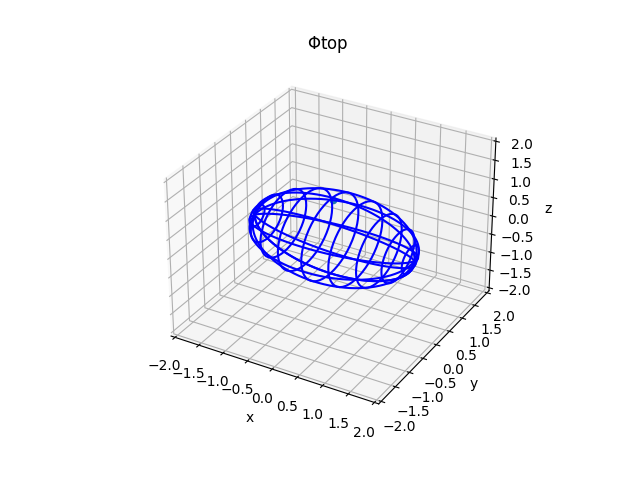

In [35]:
phitop_v = sym.lambdify([sym.Symbol("alpha"), sym.Symbol("beta"), sym.Symbol("theta_y")],phitop.subs({sym.Symbol('a'):phi_v, sym.Symbol('c'): 1, sym.Symbol('r'): 1}), 'numpy')
phitop_v

def plot_phitop(axes, theta_y):
    alphas, betas = np.meshgrid(np.linspace(0,np.pi,resolution),np.linspace(-np.pi,np.pi,resolution))
    data = phitop_v(alphas, betas, theta_y)
    return axes.plot_wireframe(data[0,0],data[1,0],data[2,0],color="b", rstride=5, cstride=5)

def display_phitop():
    phitop_plot = None
    point_plot = None
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection="3d")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    ax.set_zlim([-2,2])

    def update(theta_y = 0, alpha=np.pi/2, beta=0):
        nonlocal phitop_plot, point_plot
        if phitop_plot:
            phitop_plot.remove()
            
        if point_plot:
            point_plot.remove()
            
        phitop_plot = plot_phitop(ax, theta_y)
        point = phitop_v(alpha,beta,theta_y)
        point_plot = ax.scatter(point[0], point[1], point[2])
        fig.canvas.draw_idle()

    plt.title(r'$\Phi$top')

    interact(update, alpha=(0,np.pi,0.01), beta=(-np.pi,np.pi,0.01), theta_y=(0,np.pi/2,0.01))
    
display_phitop()

## Potential Energy

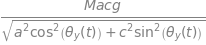

In [36]:
def derive_potential_energy():
    M, g, a, c, t= sym.symbols("M, g, a, c, t")
    theta_y = sym.Function("theta_y")(t)
    return M * g * a * c / (sym.sqrt(a**2*sym.sin(sym.pi/2 - theta_y)**2 + c**2*sym.cos(sym.pi/2-theta_y)**2))
potential_energy = derive_potential_energy()
potential_energy

The potential energy of the spheroid is distance of the centre of mass (which is also the physical centre) to the lowest point on the egg for any $\theta$. This is simply the radius of the cross-sectional ellipse at the appropriate angle. In general, the radius of an ellipse at angle $\psi$ from the horizontal is given by:

$$
r = \frac{ab}{\sqrt{a^2\sin^2\psi + c^2\cos^2\psi}}
$$

so in our particular case, the angle from the horizontal is $\psi = \frac{\pi}{2} - {}^T\theta_y$, therefore:

$$
\mathcal{U} = \frac{Mga}{\sqrt{\phi^2\cos^2{}^T\theta_y + \sin^2{}^T\theta_y}}
$$

Intuitively this potential energy does not change if we shift our frame of reference to $G$.

## Moment of Inertia

In [39]:
def derive_moment_of_inertia():
    x,z,y = sym.symbols("x y z")
    a, c, alpha, beta, r, rho, M = sym.symbols("a c alpha beta r rho M")
    
    def moment_of_inertia_integrand():
        m = rho * sym.Matrix([
            [y**2 + z**2, -x*y, -x*z],
            [-x*y, x**2 + z**2, -y*z],
            [-x*z, -y*z, x**2 + y**2]
        ])
        return m

    # r^2 sin (alpha) term required for integration in spherical co-ordinates
    parametric_integrand = a * c ** 2 * moment_of_inertia_integrand().subs({x: phitop[0], y: phitop[1], z: phitop[2]}) * r ** 2 * sym.sin(alpha)
    moi_by_alpha = sym.Integral(parametric_integrand,(alpha,0,sym.pi)).doit()
    moi_by_beta = sym.Integral(moi_by_alpha,(beta,-sym.pi,sym.pi)).doit()
    moi_by_r = sym.Integral(moi_by_beta,(r,0,1)).doit()
    moi = moi_by_r.subs(rho, 3 * M / (4 * sym.pi * a * c **2))
    return moi
moment_of_inertia = derive_moment_of_inertia().simplify()
moment_of_inertia

⎡  ⎛ 2    2         2    2         2⎞                       ⎛   2    2⎞                 ⎤
⎢M⋅⎝a ⋅sin (θ_y) + c ⋅cos (θ_y) + c ⎠                     M⋅⎝- a  + c ⎠⋅sin(2⋅θ_y)      ⎥
⎢────────────────────────────────────       0             ────────────────────────      ⎥
⎢                 5                                                  10                 ⎥
⎢                                                                                       ⎥
⎢                                        ⎛ 2    2⎞                                      ⎥
⎢                                      M⋅⎝a  + c ⎠                                      ⎥
⎢                 0                    ───────────                   0                  ⎥
⎢                                           5                                           ⎥
⎢                                                                                       ⎥
⎢        ⎛   2    2⎞                                  ⎛ 2    2         2    2         2⎞⎥
⎢      M⋅⎝

From [Mathworld](https://scienceworld.wolfram.com/physics/MomentofInertia.html) we can see that the moment of inertia is defined by:

$$
I \equiv \int_V \rho \begin{bmatrix}
y^2 + z^2 & -xy & -xz \\
-xy & x^2 + z^2 & -yz \\
-xz & -yz & x^2 + y^2 
\end{bmatrix}dV
$$

Subsituting in our earlier values for $x$ and $y$ we get:

$$
I \equiv \int_0^1 \int_{-\pi}^{\pi} \int_0^\pi\rho\left[\begin{matrix}\left(\phi \sin{\left(\theta \right)} \cos{\left(\alpha \right)} + \sin{\left(\alpha \right)} \cos{\left(\beta \right)} \cos{\left(\theta \right)}\right)^{2} + \sin^{2}{\left(\alpha \right)} \sin^{2}{\left(\beta \right)} & - \left(\phi \cos{\left(\alpha \right)} \cos{\left(\theta \right)} - \sin{\left(\alpha \right)} \sin{\left(\theta \right)} \cos{\left(\beta \right)}\right) \sin{\left(\alpha \right)} \sin{\left(\beta \right)} & - \left(\phi \sin{\left(\theta \right)} \cos{\left(\alpha \right)} + \sin{\left(\alpha \right)} \cos{\left(\beta \right)} \cos{\left(\theta \right)}\right) \left(\phi \cos{\left(\alpha \right)} \cos{\left(\theta \right)} - \sin{\left(\alpha \right)} \sin{\left(\theta \right)} \cos{\left(\beta \right)}\right)\\- \left(\phi \cos{\left(\alpha \right)} \cos{\left(\theta \right)} - \sin{\left(\alpha \right)} \sin{\left(\theta \right)} \cos{\left(\beta \right)}\right) \sin{\left(\alpha \right)} \sin{\left(\beta \right)} & \left(\phi \sin{\left(\theta \right)} \cos{\left(\alpha \right)} + \sin{\left(\alpha \right)} \cos{\left(\beta \right)} \cos{\left(\theta \right)}\right)^{2} + \left(\phi \cos{\left(\alpha \right)} \cos{\left(\theta \right)} - \sin{\left(\alpha \right)} \sin{\left(\theta \right)} \cos{\left(\beta \right)}\right)^{2} & - \left(\phi \sin{\left(\theta \right)} \cos{\left(\alpha \right)} + \sin{\left(\alpha \right)} \cos{\left(\beta \right)} \cos{\left(\theta \right)}\right) \sin{\left(\alpha \right)} \sin{\left(\beta \right)}\\- \left(\phi \sin{\left(\theta \right)} \cos{\left(\alpha \right)} + \sin{\left(\alpha \right)} \cos{\left(\beta \right)} \cos{\left(\theta \right)}\right) \left(\phi \cos{\left(\alpha \right)} \cos{\left(\theta \right)} - \sin{\left(\alpha \right)} \sin{\left(\theta \right)} \cos{\left(\beta \right)}\right) & - \left(\phi \sin{\left(\theta \right)} \cos{\left(\alpha \right)} + \sin{\left(\alpha \right)} \cos{\left(\beta \right)} \cos{\left(\theta \right)}\right) \sin{\left(\alpha \right)} \sin{\left(\beta \right)} & \left(\phi \cos{\left(\alpha \right)} \cos{\left(\theta \right)} - \sin{\left(\alpha \right)} \sin{\left(\theta \right)} \cos{\left(\beta \right)}\right)^{2} + \sin^{2}{\left(\alpha \right)} \sin^{2}{\left(\beta \right)}\end{matrix}\right]d\alpha d\beta dr
$$

and evaluating:

$$
I = \begin{pmatrix}\frac{4 \pi \rho \left(a^{2} \sin^{2}{\left(\theta_{y} \right)} + c^{2} \cos^{2}{\left(\theta_{y} \right)} + c^{2}\right)}{15} & 0 & \frac{2 \pi \rho \left(- a^{2} + c^{2}\right) \sin{\left(2 \theta_{y} \right)}}{15}\\0 & \frac{4 \pi \rho \left(a^{2} + c^{2}\right)}{15} & 0\\\frac{2 \pi \rho \left(- a^{2} + c^{2}\right) \sin{\left(2 \theta_{y} \right)}}{15} & 0 & \frac{4 \pi \rho \left(a^{2} \cos^{2}{\left(\theta_{y} \right)} + c^{2} \sin^{2}{\left(\theta_{y} \right)} + c^{2}\right)}{15}\end{pmatrix}
$$

## Kinetic Energy

### Kinetic Energy about ${}\theta_y$

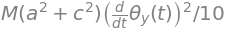

In [40]:
def derive_theta_y_kinetic_energy():
    theta_y = sym.Function("theta_y")(t)
    theta_y_dot = sym.diff(theta_y,t)
    theta_dot_vec = sym.Matrix([0,theta_y_dot,0])
    return (sym.Rational(1,2) * theta_dot_vec.T * moment_of_inertia * theta_dot_vec)[0].simplify()
theta_y_kinetic_energy = derive_theta_y_kinetic_energy()
theta_y_kinetic_energy

If the spheroid is placed on a surface with its ${}^Tx$-axis not parallel to that surface then observation shows that it will oscillate about the ${}^Ty$-axis. It is helpful to derive these equations of motion to validate our representation thus far. Let's derive the kinetic energy in this case, combine that with the potential energy from earlier to derive a Langrangian, and solve the Euler-Lagrange equations for this restricted case of spheroid motion. Note that in this restricted case, ${}^G\theta_z = 0$ and so $G$ = $T$ and we can therefore avoid specifying the frame of reference for every symbol.

Rotational velocity about the $y$-axis is repsented by the $\boldsymbol{\dot{\theta}}$ vector:

$$
\boldsymbol{\dot{\theta}} = \begin{pmatrix}
0 \\
{}\dot{\theta}_y \\
0 \\
\end{pmatrix}
$$

$$
\begin{align}
\mathcal{T} &= \frac{1}{2}\dot{\boldsymbol{\theta}}^TI\dot{\boldsymbol{\theta}} \\
&= \frac{\pi^{2} \rho \left(2 a^2 + c^2\right) \dot{\theta_{y}}^{2}}{4}
\end{align}
$$

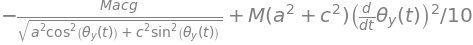

In [41]:
def derive_theta_y_lagrangian():
    return theta_y_kinetic_energy - potential_energy
theta_y_lagrangian = derive_theta_y_lagrangian()
theta_y_lagrangian


Our Lagrangian for this restricted case is therefore:

$$
\mathcal{L} = \frac{\pi^{2}\rho \left(2 a + c^2\right) \dot{\theta_{y}}^{2}}{4} - \frac{Mag\phi}{\sqrt{a^2\cos^2\theta_y + c^2\sin^2\theta_y}}
$$

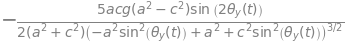

In [42]:
def derive_theta_y_euler_lagrange():
    # do a new L with theta_y_dot as a seperate symbol so that we can do the partials
    F, t = sym.symbols("F t")
    theta_y = sym.Function("theta_y")(t)
    theta_y_dot = sym.Function("theta_y_dot")(t)
    L = theta_y_lagrangian.subs(sym.Derivative(theta_y,t),theta_y_dot)

    dLdtheta_y = sym.diff(L, theta_y)
    dLdtheta_y_dot = sym.diff(L, theta_y_dot)
    ddt_dLdtheta_y_dot = sym.diff(dLdtheta_y_dot, t)
    return sym.solve(dLdtheta_y - ddt_dLdtheta_y_dot, sym.Derivative(theta_y_dot,t))[0].simplify()
theta_y_euler_lagrange = derive_theta_y_euler_lagrange()
theta_y_euler_lagrange

Taking that langrangian and applying the Euler Lagrange equation:


$$
\frac{\partial \mathcal{L}}{\partial \theta_y} - \frac{d}{dt} \frac{\partial \mathcal{L} }{\partial \dot{\theta_y}} = 0
$$

gives:

$$
\ddot{\theta_y} = 
- \frac{M a g \left(a^{2} - c^{2}\right) \sin{2 \theta_{y} }}{\pi^{2} \rho \left(2 a^{2} + c^{2}\right) \left(- a^{2} \sin^{2}{\theta_{y}} + a^{2} + c^{2} \sin^{2}{\theta_{y}}\right)^{\frac{3}{2}}}
$$

In [43]:
def calculate_real_values():
    a = 0.05108 / 2
    c = 0.03132 / 2 # meter
    M = 0.071 # Kg
    V = 4/3 * np.pi * a * c**2 # m**3
    rho = M / V # Kg*m**-3
    return a, c, M, V, rho

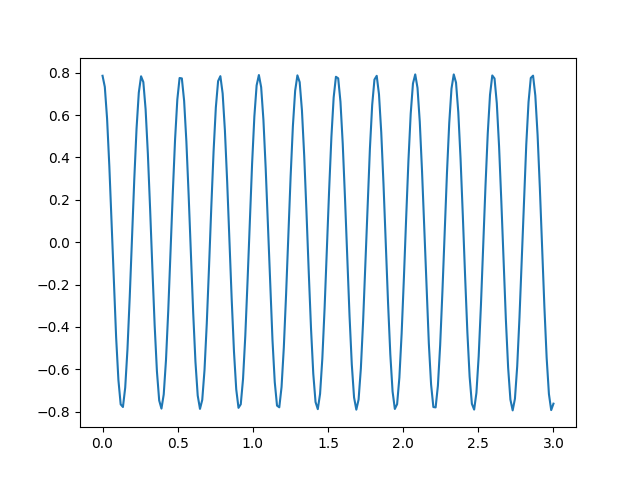

In [47]:
def solve_theta_y_euler_lagrange():
    a_v, c_v, M_v, V_v, rho_v = calculate_real_values()
    g_v = 9.8 # m * s ** -2
    a,c,M,rho,g = sym.symbols("a c M rho g")
    theta_y = sym.Function("theta_y")(t)
    
    d2theta_dt2 = sym.lambdify(theta_y, theta_y_euler_lagrange.subs({
        a: a_v,
        c: c_v,
        M: M_v,
        g: g_v,
        rho: rho_v
    }))
    
    def model(t, theta):
        return (theta[1], d2theta_dt2(theta[0]))
    
    ts = np.linspace(0, 3, resolution)
    
    sol=sp.integrate.solve_ivp(model, [0,5], [np.pi/4, 0], t_eval = ts)
    time_array=sol.t
    solution_array=sol.y
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(time_array, solution_array[0,:])

solve_theta_y_euler_lagrange()

## Rotational Kinetic Energy (draft - don't read yet)

In [12]:
def derive_rotational_kinetic_energy():
    omega_x, omega_y, omega_z = sym.symbols('omega_x omega_y omega_z')
    w = sym.Matrix([omega_x,omega_y,omega_z])
    return (sym.Rational(1,2) * w.T @ moment_of_inertia @ w)[0].simplify()
rotational_kinetic_energy = derive_rotational_kinetic_energy()

We saw earlier that

$$
\mathcal{T} = \frac{1}{2}\boldsymbol{\omega}^TI\boldsymbol{\omega}
$$

Subsituting in our value for $I$ we get:

$$
\mathcal{T} = \frac{\pi^{2} \left(\omega_{x} \left(\omega_{x} \left(2 \phi^{2} \sin^{2}{\left(\theta \right)} + \cos^{2}{\left(\theta \right)} + 1\right) - \frac{\omega_{z} \left(2 \phi^{2} - 1\right) \sin{\left(2 \theta \right)}}{2}\right) + \omega_{y}^{2} \left(2 \phi^{2} + 1\right) - \omega_{z} \left(\frac{\omega_{x} \left(2 \phi^{2} - 1\right) \sin{\left(2 \theta \right)}}{2} - \omega_{z} \left(2 \phi^{2} \cos^{2}{\left(\theta \right)} + \sin^{2}{\left(\theta \right)} + 1\right)\right)\right)}{4}
$$